# Poisson likelihood and Gamma prior

This is a simple model where our discrete data, $y$, is modelled as a Poisson RV with Gamma prior, which is a conjugate prior model.

$L(x) = p(y | x) = \mathcal{P}[y \mid x]$

and

$p(x) = \Gamma[x \mid k, \theta]$.

The analytic evidence for this model is,

$Z = p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x =  \mathcal{P}[y \mid 1] \frac{\Gamma[1 \mid k, \theta]}{\Gamma[1 \mid k', \theta']}$

The posterior is also a Gamma distribution,

$p(x \mid y) = \Gamma[x \mid k', \theta']$

where

$k' = k + \sum_i y_i$

and

$\theta' = \frac{\theta}{(\theta \sum_i y_i + 1)}$

## Overview

We'll cover the following topics:

1. How to define your prior with a `PriorChain` context.
2. How to define your likelihood
3. How to compute Bayesian evidence of your model with standard nested sampling (without much tuning of parameters).
4. How to inspect and plot your results.
5. How to save and load your results.
6. How to time your execution.
7. How to marginalise over the posterior.

In [1]:
from jaxns.nested_sampler.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, GammaPrior
from jaxns.utils import summary, resample
from jaxns.plotting import plot_cornerplot, plot_diagnostics
from jax import random, numpy as jnp, jit
from jax.scipy.special import gammaln
import pylab as plt
import numpy as np

In [2]:
# Generate data

num_samples = 10

true_k = 0.5
true_theta = 1.

_gamma = np.random.gamma(true_k, true_theta, size=num_samples)
print(f"Taking {num_samples} samples from a Poisson distribution as data.")
samples = jnp.asarray(np.random.poisson(_gamma, size=num_samples))

INFO[2022-03-03 16:04:24,711]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-03-03 16:04:24,711]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-03-03 16:04:24,712]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-03-03 16:04:24,713]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Taking 10 samples from a Poisson distribution as data.


In [3]:
# Build model
prior_k = 100.
prior_theta = 1.

with PriorChain() as prior_chain:
    GammaPrior('gamma', prior_k, prior_theta)

def log_likelihood(gamma):
    """
    Poisson likelihood.
    """
    return jnp.sum(samples * jnp.log(gamma) - gamma - gammaln(samples + 1))


In [4]:
# Evidence and posterior are analytic
def log_gamma_prob(gamma, k, theta):
    return (k-1) * jnp.log(gamma)  - gamma / theta - gammaln(k) - k * jnp.log(theta)

true_post_k = prior_k + jnp.sum(samples)
true_post_theta = prior_theta / (num_samples * prior_theta + 1.)

true_post_mean_gamma = true_post_theta * true_post_k

true_logZ = log_likelihood(1.) + log_gamma_prob(1., prior_k, prior_theta) - log_gamma_prob(1., true_post_k, true_post_theta)
print(f"True Evidence = {true_logZ}")
print(f"True posterior k = {true_post_k}")
print(f"True posterior theta = {true_post_theta}")
print(f"True posterior gamma = {true_post_mean_gamma}")


True Evidence = -225.2459347893813
True posterior k = 110.0
True posterior theta = 0.09090909090909091
True posterior gamma = 10.0


In [5]:
# Run the nested sampling
ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain)

f = jit(ns)

results = f(random.PRNGKey(3452345), num_live_points=1000)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 29254
# samples: 987
# likelihood evals / sample: 29.6
--------
logZ=-225.58 +- 0.19
H=47.0
ESS=160
--------
gamma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.


WARNING[2022-03-03 16:04:33,329]: No handles with labels found to put in legend.


gamma: 10.1 +- 1.0 | 8.8 / 9.9 / 11.5 | 10.8 | 9.9
--------


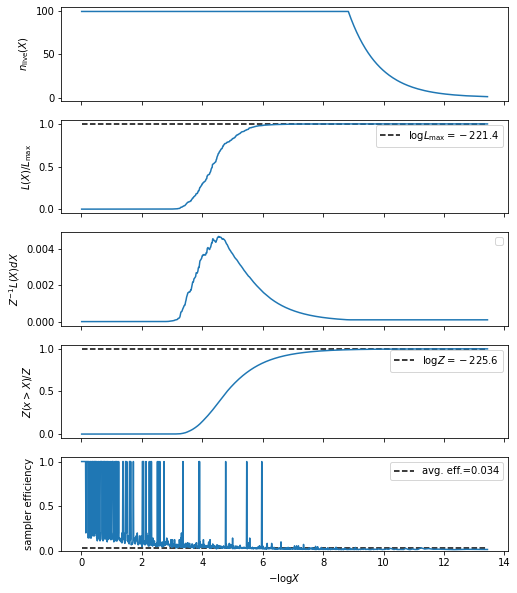

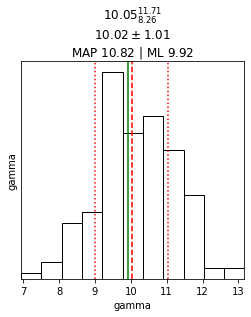

In [6]:
# Inspect results
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

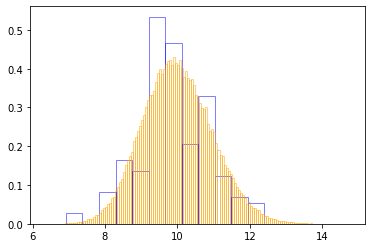

In [7]:
# Comparing samples to true posterior

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['gamma'], bins='auto', ec='blue', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_post_k, true_post_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.5, density=True, fc='none')
plt.show()

In [ ]:

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['gamma'], bins='auto', ec='blue', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_post_k, true_post_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.5, density=True, fc='none')
plt.show()

In [ ]:

summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['gamma'], bins='auto', ec='blue', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_post_k, true_post_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.5, density=True, fc='none')
plt.show()

In [ ]:

ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain,
                   dynamic=True,
                   sampler_kwargs=dict(midpoint_shrink=False))

f = jit(ns)

results = f(random.PRNGKey(3452345), terminate_evidence_uncert=1e-2, terminate_max_num_threads=20,
            dynamic_kwargs=dict(f=0.7, G=0.))
print(results.thread_stats)
summary(results)

plot_diagnostics(results)
plot_cornerplot(results)

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['gamma'], bins='auto', ec='blue', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_post_k, true_post_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.5, density=True, fc='none')
plt.show()